In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import RobustScaler
from joblib import Parallel, delayed
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

In [4]:
data_dir = 'drive/My Drive/Colab Notebooks/230T2/Data/'
norm_features = pd.read_csv(data_dir + 'norm_features.csv', index_col=0, parse_dates=True)
label = pd.read_csv(data_dir + 'label.csv', index_col=0, parse_dates=True)['0']

In [ ]:
label.dropna()

Time
2016-05-10 14:40:00    0.306164
2016-05-10 15:20:00   -0.116551
2016-05-10 15:30:00   -0.105559
2016-05-10 15:40:00   -0.032994
2016-05-10 15:50:00    0.125488
                         ...   
2019-01-07 20:30:00   -0.218711
2019-01-07 20:40:00   -0.021177
2019-01-07 20:50:00    0.141083
2019-01-07 21:00:00   -0.003744
2019-01-07 21:10:00   -0.221921
Name: 0, Length: 135740, dtype: float64

In [ ]:
display(label.describe())
norm_features.describe()

count    135740.000000
mean          0.009462
std           0.971153
min         -23.391706
25%          -0.248917
50%           0.015641
75%           0.296545
max          17.908958
Name: 0, dtype: float64

,relative_vol,return,rela_HML,Rvol,return_ETH,price_diff_1h,price_diff_12h
count,132835.000000,135489.000000,138159.000000,137782.000000,134652.000000,138047.000000,135515.000000
mean,-0.003359,0.015951,-0.101944,-0.111819,0.009980,-0.001631,0.004360
std,0.797240,1.247676,0.886476,0.888530,1.458095,1.246830,1.225912
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.506811,-0.473946,-0.525153,-0.527093,-0.474382,-0.491710,-0.459797
50%,0.000003,0.000015,0.000571,0.000497,0.000000,0.000208,0.000221
75%,0.493189,0.526596,0.474664,0.473046,0.528221,0.509096,0.540897
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [ ]:
norm_features


,relative_vol,return,rela_HML,Rvol,return_ETH,price_diff_1h,price_diff_12h
Time,,,,,,,
2016-05-10 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 13:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 13:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 14:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2019-01-07 21:20:00,0.352456,-0.163541,-0.228866,-0.182309,-0.246363,-0.004992,-0.054930
2019-01-07 21:30:00,0.031618,-0.426442,-0.211422,-0.225059,-1.326428,-0.125991,-0.083215
2019-01-07 21:40:00,-0.038978,0.405179,-0.579771,-0.325312,-3.000000,0.089472,-0.107827


* Dropping missing values

In [ ]:
def nandetector(x, threshold=10):
    return np.sum(np.isnan(x)) > threshold  # true if there is more than 10 nan

def get_input_output(norm_features, label, window=36):
    shape = (len(label), window, norm_features.shape[1])
    input_data = np.zeros(shape)

    for t in range(window):
        input_data[:, t, :] = norm_features.shift(window-1 - t)
        
    flag_nan_input = np.zeros(len(input_data))
    for i in range(len(input_data)):
        flag_nan_input[i] = nandetector(input_data[i])    
    flag_nan_output = label.apply(np.isnan)

    flag_nan = (flag_nan_output.values + flag_nan_input).astype(bool)
    flag_nan = pd.Series(flag_nan, index=label.index)

    ## get inputs, outputs
    inputs = input_data[flag_nan.values==False]
    inputs[np.isnan(inputs)] = 0.0  

    outputs = label.values[flag_nan.values==False]
    return (inputs, outputs, flag_nan )

In [ ]:
nlags = 36
inputs, outputs, flag_nan = get_input_output(norm_features, label, window=nlags)

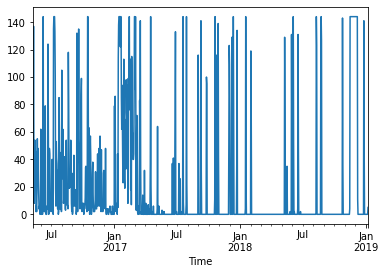

In [ ]:
flag_nan.groupby(pd.Grouper(freq='d')).sum().plot()

In [ ]:
np.save(data_dir + 'inputs', inputs)
np.save(data_dir + 'outputs', outputs)

* Train the model

In [ ]:
import keras.backend as K
def right_direction(y_true, y_pred):
    length = K.shape(y_true)[0]
    pmn = K.sum(K.sign(y_true * y_pred)) ## positive - negative
    ppn = K.sum(K.abs(K.sign(y_true * y_pred)))
    wrong_rate = (ppn + pmn) /2/ ppn
    return wrong_rate * 100

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  fig, ax = plt.subplots()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('MSE')
  ax.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  ax.legend()
  ax1 = ax.twinx()
  ax1.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error', color='r')
#   plt.ylim([0,])
  ax1.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['right_direction'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_right_direction'],
           label = 'Val Accuracy', color='r')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()

def build_model1(units=12, nlags=10, nfeatures=7 ,seed=1):
    
    model = keras.Sequential([
#         layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.BatchNormalization(trainable=True),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', return_sequences=False, input_shape=(nlags, nfeatures)),
#         layers.LSTM(units=units, activation='tanh', recurrent_activation='tanh'),
        layers.Dense(10, activation='relu'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=[right_direction, 'mse'])
    return model

def build_model(units=12, nlags=10, nfeatures=7, seed=1):
#     tf.random.set_seed(seed)
    model = keras.Sequential([
#         layers.Dense(8, input_shape=(nlags, 5), activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
#         layers.BatchNormalization(trainable=True),
#         layers.Dense(12, activation='relu', kernel_regularizer=keras.regularizers.L2(0.0)),
#         layers.Dropout(rate=0.1),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(nlags, nfeatures)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=[right_direction, 'mse'])
    return model

In [ ]:

# nlags=36
initial_epoch=0
tf.random.set_seed(0)
nfeatures = norm_features.shape[1]
model = build_model(nlags=nlags, nfeatures=nfeatures)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 36, 12)            960       
_________________________________________________________________
dropout (Dropout)            (None, 36, 12)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1200      
_________________________________________________________________
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

Epoch 1/300
1/1 [==============================] - 1s 725ms/step - loss: 0.9396 - right_direction: 49.5231 - mse: 1.9955 - val_loss: 0.3263 - val_right_direction: 50.5279 - val_mse: 0.3296
Epoch 2/300
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 37ms/step - loss: 0.8960 - right_direction: 49.1215 - mse: 1.8090 - val_loss: 0.3246 - val_right_direction: 51.0307 - val_mse: 0.3276
Epoch 3/300
1/1 [==============================] - 0s 36ms/step - loss: 0.8542 - right_direction: 49.2219 - mse: 1.6540 - val_loss: 0.3233 - val_right_direction: 50.9301 - val_mse: 0.3261
Epoch 4/300
1/1 [==============================] - 0s 37ms/step - loss: 0.8132 - right_direction: 49.5858 - mse: 1.5000 - val_loss: 0.3223 - val_right_direction: 50.5279 - val_mse: 0.3250
Epoch 5/300
1/1 [==============================] - 0s 37ms/step - loss: 0.7686 - right_direction: 49.7741 - mse: 1.3453 - val_loss: 0.3217 - val_right_direction: 51.1312 - val

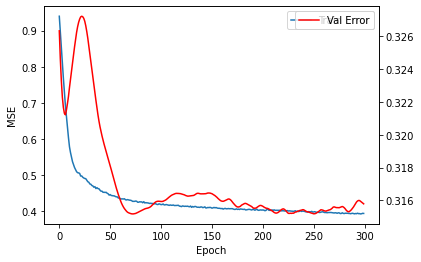

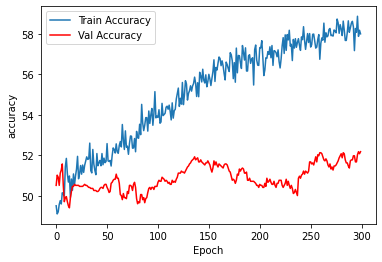

In [ ]:
size = 10000

train_data = inputs[:size]
train_label = outputs[:size]

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 300
tf.random.set_seed(1)
history = model.fit(
    train_data, train_label, batch_size=10000, shuffle=True ,epochs=EPOCHS, validation_split=0.2, 
    verbose=1, callbacks=[PrintDot(), tensorboard_callback])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history)

In [ ]:
model.save_weights(data_dir + 'model_weights01')

(1000,) (1000,)


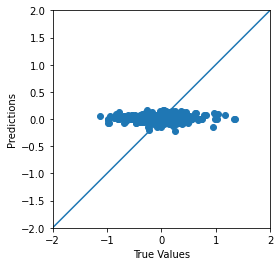

In [ ]:
test_data = inputs[size:size+1000]
test_labels = outputs[size:size+1000]
test_predictions = model.predict(test_data).flatten()
print(test_labels.shape, test_predictions.shape)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
lim=2
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
_ = plt.plot([-lim, lim], [-lim, lim])

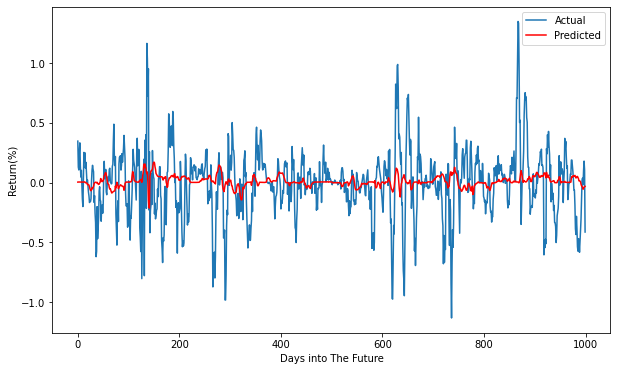

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', c='r')
plt.ylabel("Return(%)")
plt.xlabel('Days into The Future')
plt.legend()
plt.show()

* Next steps:
  * Making predictions for given time period.
  * Build and test the prediction performance on a strategy


In [ ]:
norm_features

,relative_vol,return,rela_HML,Rvol,return_ETH,price_diff_1h,price_diff_12h
Time,,,,,,,
2016-05-10 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 13:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 13:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-10 14:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2019-01-07 21:20:00,0.352456,-0.163541,-0.228866,-0.182309,-0.246363,-0.004992,-0.054930
2019-01-07 21:30:00,0.031618,-0.426442,-0.211422,-0.225059,-1.326428,-0.125991,-0.083215
2019-01-07 21:40:00,-0.038978,0.405179,-0.579771,-0.325312,-3.000000,0.089472,-0.107827


In [ ]:
flag_nan

Time
2016-05-10 13:30:00    True
2016-05-10 13:40:00    True
2016-05-10 13:50:00    True
2016-05-10 14:00:00    True
2016-05-10 14:10:00    True
                       ... 
2019-01-07 21:20:00    True
2019-01-07 21:30:00    True
2019-01-07 21:40:00    True
2019-01-07 21:50:00    True
2019-01-07 22:00:00    True
Length: 140020, dtype: bool

In [ ]:
flag_nan.loc['2019-01-07 20:00:00':]

Time
2019-01-07 20:00:00    False
2019-01-07 20:10:00    False
2019-01-07 20:20:00    False
2019-01-07 20:30:00    False
2019-01-07 20:40:00    False
2019-01-07 20:50:00    False
2019-01-07 21:00:00    False
2019-01-07 21:10:00    False
2019-01-07 21:20:00     True
2019-01-07 21:30:00     True
2019-01-07 21:40:00     True
2019-01-07 21:50:00     True
2019-01-07 22:00:00     True
dtype: bool

In [ ]:
def time_to_index(time, flag_nan=flag_nan):
    return np.sum(flag_nan[flag_nan.index < time] == False)

def making_prediction(model, start_time, end_time, flag_nan=flag_nan):
    """
    First, find corresponding valid input samples within this period
    Second, make predictions for the valid samples
    Third, return predictions for every 10-min during this period

    Args:
      model: the trained LSTM model
      start_time: should be no earlier than '2016-05-10 13:30:00' (included)
      end_time: should be no later than '2019-01-07 22:00:00'  (included)
    """
    start, end = time_to_index(start_time), time_to_index(end_time)+1
    test_data = inputs[start:end]
    test_pred = model.predict(test_data).flatten()
    
    temp_flag = flag_nan.loc[start_time: end_time]
    predictions = pd.Series(np.full(len(temp_flag), np.nan), index=temp_flag.index)
    predictions[temp_flag==False] = test_pred 
    return predictions

In [ ]:
time_to_index('2016-08-12 00:00:00')

10323

In [ ]:
a = pd.Series([1]*10)
a[a.index < 5] = [1,2,3,4,5]
a

0    1
1    2
2    3
3    4
4    5
5    1
6    1
7    1
8    1
9    1
dtype: int64

In [ ]:
flag_nan.loc['2016-08-12 00:00:00': '2016-08-12 01:00:00']

Time
2016-08-12 00:00:00    False
2016-08-12 00:10:00    False
2016-08-12 00:20:00    False
2016-08-12 00:30:00    False
2016-08-12 00:40:00    False
2016-08-12 00:50:00    False
2016-08-12 01:00:00    False
dtype: bool

In [ ]:
preds = making_prediction(model, '2016-08-12 00:00:00', '2016-10-12 00:00:00')
preds

Time
2016-08-12 00:00:00   -0.144350
2016-08-12 00:10:00   -0.108049
2016-08-12 00:20:00   -0.041231
2016-08-12 00:30:00   -0.049758
2016-08-12 00:40:00   -0.052844
                         ...   
2016-10-11 23:20:00   -0.022667
2016-10-11 23:30:00   -0.004189
2016-10-11 23:40:00    0.005539
2016-10-11 23:50:00   -0.002429
2016-10-12 00:00:00    0.010618
Length: 8785, dtype: float64

In [ ]:
ret_10min = pd.read_csv(data_dir + 'ret_10min.csv', index_col=0, parse_dates=True)['0']
ret_10min

Time
2016-05-09 13:30:00         NaN
2016-05-09 13:40:00   -0.000498
2016-05-09 13:50:00    0.000563
2016-05-09 14:00:00    0.000758
2016-05-09 14:10:00   -0.000087
                         ...   
2019-01-07 21:20:00   -0.000877
2019-01-07 21:30:00    0.000850
2019-01-07 21:40:00    0.000299
2019-01-07 21:50:00   -0.002015
2019-01-07 22:00:00   -0.000145
Name: 0, Length: 140164, dtype: float64

In [ ]:
np.nan < 0

False

In [ ]:
def test_signal(y_pre, threshold=1):
    flag_p = y_pre > threshold
    flag_n = y_pre < -threshold
    return (flag_p, flag_n)

def stra_performance(flag_n, flag_p, ret_23, label='long-short', mode='test'):
    time = ret_23.index
    ret_23 = ret_23.values
    stra_ret = np.zeros(len(ret_23))
    # flag = (trends[11] > 0) & (trends[11]<5)
    # flag_1 = (trends_1[11] < 0) & (trends_1[11]>-5)
    dates = range(len(ret_23))
    flag_p = flag_p.squeeze()
    flag_n = flag_n.squeeze()
    stra_ret[flag_n] = ret_23[flag_n]
    stra_ret[flag_p] = -ret_23[flag_p]
    stra_ret[np.isnan(stra_ret)] = 0
    earnings  = [0]
    count_trades = np.count_nonzero(stra_ret)
    print(label, ": ")
    print("# of trading：", count_trades, ";   winning rate：", np.count_nonzero(stra_ret > 0) / count_trades)
    for i in range(len(stra_ret)):
        earnings.append(stra_ret[i] + earnings[-1])
    # tdays = stra_ret != 0
    stra_ret = pd.Series(stra_ret, index=time)
    daily_ret = stra_ret.groupby(pd.Grouper(freq='d')).sum()
    Sharpe = daily_ret.mean() / daily_ret.std() * np.sqrt(252)
    print("Sharpe：", Sharpe)
    plt.plot(earnings, label="Sharpe Ratio = {:.4}".format(Sharpe))
    plt.xlabel("Dates")
    plt.legend()
    plt.ylabel("Return")
    plt.title("Return on {} set".format(mode))
    plt.show()
    return stra_ret
    
def back_test(model, start_time, end_time, threshold=0.5, ret_10min=ret_10min, mode='test'):
    test_predictions = making_prediction(model, start_time, end_time)
    flag_p, flag_n = test_signal(test_predictions.values, threshold)
    stra_performance(flag_p, flag_n, ret_10min.loc[start_time: end_time], mode=mode)


In [ ]:
def test_signal(y_pre, vol_threshold_span=100, ewm_span=100, open_constant=1, close_constant=0.75):
  ewm_preds = y_pre.ewm(adjust=False, span=ewm_span).mean()
  vol_thresholds = y_pre.rolling(vol_threshold_span).std()
  flag_sp = y_pre > open_constant*vol_thresholds
  flag_sn = y_pre < -open_constant*vol_thresholds
  flag_wp = y_pre > close_constant*vol_thresholds
  flag_wn = y_pre < -close_constant*vol_thresholds
  return (flag_sp, flag_sn, flag_wp, flag_wn)

def stra_performance(flag_sp, flag_sn, flag_wp, flag_wn, ret_23, start_num=2000, end_num=3000, label='long-short', mode='test', trading_cost=0.15/100, show=True):
  stra_ret = np.zeros(len(ret_23))
  portfolio = np.zeros(len(ret_23))
  time = ret_23.index
  ret_23 = ret_23.values
  position = 0
  count_trades = 0
  earnings  = [0]
  for i in range(len(ret_23)):
    if position == 0:
      if flag_sp[i]:
        position = 1
        stra_ret[i] = ret_23[i] - trading_cost
        count_trades += 1
      elif flag_sn[i]:
        position = -1
        stra_ret[i] = -ret_23[i] - trading_cost
        count_trades += 1
      else:
        stra_ret[i] = 0
    elif (flag_wn[i] and position == 1) or (flag_wp[i] and position == -1):
      position = 0
      stra_ret[i] = -trading_cost
      count_trades += 1
    else:
      stra_ret[i] = ret_23[i] if position > 0 else -ret_23[i]
  nan_filter = np.any([~np.isnan(ret_23), stra_ret == 0], axis=0)
  stra_ret = stra_ret[nan_filter]
  for i in range(len(stra_ret)):
    earnings.append(stra_ret[i] + earnings[-1])
  daily_ret = pd.Series(stra_ret, index=time[nan_filter]).groupby(pd.Grouper(freq='d')).sum()
  Sharpe = daily_ret.mean() / daily_ret.std() * np.sqrt(365)
  if show:
    print(label, ": ")
    print("Trades: ", count_trades, "; Daily Sharpe：", Sharpe)
    plt.figure(figsize=(20,10))
    plt.plot(pd.Series(earnings[1:], index=time[nan_filter]), label="Daily Sharpe Ratio = {:.4}".format(Sharpe))
    plt.xlabel("Dates")
    plt.legend()
    plt.ylabel("Return")
    plt.title("Return on {} set".format(mode))
    plt.show()
  return earnings[-1], Sharpe
    
def back_test(start_time=0, end_time=2000, ret_10min=ret_10min, vol_threshold_span=100, ewm_span=100, open_constant=1, close_constant=0.75, mode='test', show=True, preds=None):
  'weak and strong signals specified in % points (for ex. 0.3 = 0.3% or a return of 0.003)'
  if preds is None:
    test_predictions = making_prediction(model, start_time, end_time)
  else:
    test_predictions = preds
  flag_sp, flag_sn, flag_wp, flag_wn = test_signal(test_predictions, vol_threshold_span=vol_threshold_span, ewm_span=ewm_span, open_constant=open_constant, close_constant=close_constant)
  return stra_performance(flag_sp, flag_sn, flag_wp, flag_wn, ret_10min.loc[start_time: end_time], start_time, end_time, mode=mode, show=show)


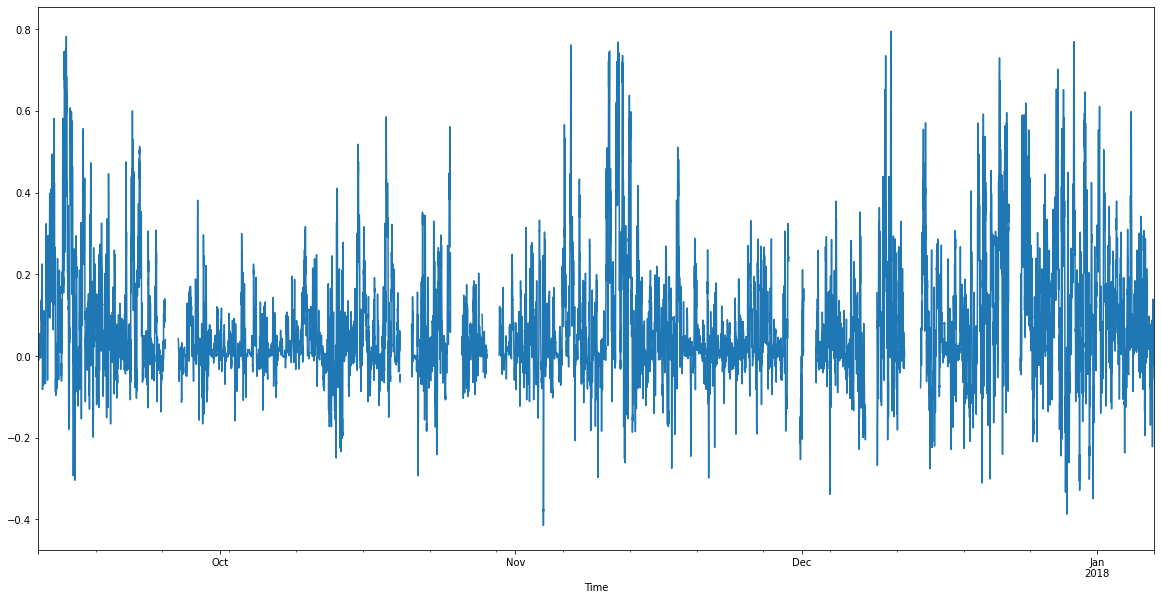

In [ ]:
plt.figure(figsize=(20, 10))
making_prediction(model, '2017-09-12 00:00:00', '2018-01-07 00:00:00').plot()

In [ ]:
# Grid search for ideal weak and strong cutoffs:
port_sr = []
constants = []
count = 0
for open_constant in np.linspace(0.25, 5, num=20, endpoint=True):
  for close_constant in np.linspace(0.25, 5, num=20, endpoint=True):
    if count % 100 == 0:
      print("Completed", count, "cross validations")
    port, sr = back_test(start_time='2018-01-07 00:00:00', end_time='2018-03-12 00:00:00', vol_threshold_span=144, ewm_span=100, open_constant=open_constant, close_constant=close_constant, mode='test', show=False)
    port_sr.append([open_constant, close_constant, port, sr])
    count += 1


Completed 0 cross validations
Completed 100 cross validations
Completed 200 cross validations
Completed 300 cross validations


long-short : 
Trades:  129 ; Daily Sharpe： -3.57271026551896


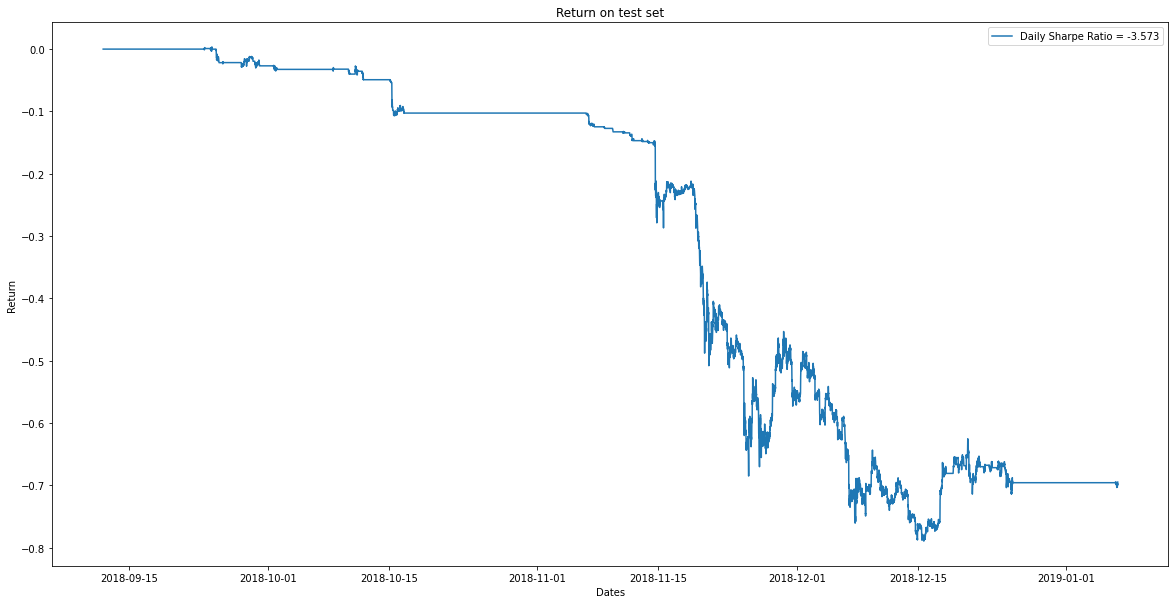

(-0.6948029822901249, -3.57271026551896)

In [ ]:
back_test(start_time='2018-09-12 00:00:00', end_time='2019-01-07 00:00:00', vol_threshold_span=1440, ewm_span=100, open_constant=2, close_constant=0.1, mode='test', show=True)

In [ ]:
test_predictions = making_prediction(model, start_time='2017-09-12 00:00:00', end_time='2018-01-07 00:00:00')

In [ ]:
calibrations = pd.DataFrame(port_sr)
calibrations = calibrations.rename({"1": "Weak Signal", "2": "Strong Signal", "3": "Portfolio Final Value", "4": "Sharpe Ratio (Daily)"})
calibrations.columns = ["Open Constant", "Close Constant", "Portfolio Final Value", "Sharpe Ratio (Daily)"]
calibrations = calibrations.sort_values(by=['Portfolio Final Value', "Sharpe Ratio (Daily)"], ascending=False).reset_index(drop=True)

calibrations.head(400)

,Open Constant,Close Constant,Portfolio Final Value,Sharpe Ratio (Daily)
0,4.25,0.75,0.125710,1.673046
1,4.25,1.00,0.059726,0.593698
2,3.50,0.25,0.049897,0.679207
3,4.25,1.25,0.031183,0.226063
4,5.00,0.25,0.024268,1.169150
...,...,...,...,...
395,0.75,0.50,-0.881614,-4.586925
396,0.25,0.75,-0.887403,-4.739616
397,0.75,0.25,-0.889629,-4.972859
398,0.25,0.50,-0.948470,-4.629282


In [ ]:
np.linspace(0.5, 4.5, num=5, endpoint=True)

array([0.5, 1.5, 2.5, 3.5, 4.5])

In [ ]:
def cross_validate(start_time, end_time, preds=None, vol_threshold_span=144, ewm_span=100):
  port_sr = []
  for open_constant in np.linspace(0.5, 4.5, num=5, endpoint=True):
    for close_constant in np.linspace(0.5, 4.5, num=5, endpoint=True):
      port, sr = back_test(start_time=start_time, end_time=end_time, vol_threshold_span=vol_threshold_span, ewm_span=ewm_span, open_constant=open_constant, close_constant=close_constant, mode='test', show=False, preds=preds)
      port_sr.append([open_constant, close_constant, port, sr])
  calibrations = pd.DataFrame(port_sr)
  calibrations.columns = ["Open Constant", "Close Constant", "Portfolio Final Value", "Sharpe Ratio (Daily)"]
  calibrations = calibrations.sort_values(by=['Portfolio Final Value', "Sharpe Ratio (Daily)"], ascending=False).reset_index(drop=True)
  return calibrations

In [ ]:
def test(start_time, end_time, open_constant, close_constant, preds=None, vol_threshold_span=144, ewm_span=100):
  ret, sr = back_test(start_time=start_time, end_time=end_time, vol_threshold_span=vol_threshold_span, ewm_span=ewm_span, open_constant=open_constant, close_constant=close_constant, mode='test', show=False, preds=preds)
  return ret, sr

In [ ]:
preds = pd.read_csv("../Data/predictions.csv", index_col=0, parse_dates=True)
preds = pd.Series(preds['0'])
cv_start_time = preds.index[0]
cv_end_time = cv_start_time + datetime.timedelta(days=30)
test_start_time = cv_end_time + datetime.timedelta(seconds=1)
test_end_time = test_start_time + datetime.timedelta(days=60)
test_results = []
while test_start_time < preds.index.max():
  cv_preds = preds[(preds.index >= cv_start_time) & 
                   (preds.index <= cv_end_time)]
  test_preds = preds[(preds.index >= test_start_time) & 
                     (preds.index <= test_end_time)]
  calibrations = cross_validate(cv_start_time, cv_end_time, preds=cv_preds)
  open_constant = calibrations['Open Constant'][0]
  close_constant = calibrations['Close Constant'][0]
  cv_return = calibrations['Portfolio Final Value'][0]
  cv_sr = calibrations['Sharpe Ratio (Daily)'][0]
  test_return, test_sr = test(test_start_time, test_end_time, open_constant=open_constant, close_constant=close_constant, preds=test_preds)
  test_results.append([test_start_time, test_end_time,  open_constant, close_constant, cv_return, cv_sr, test_return, test_sr])
  cv_start_time += datetime.timedelta(days=90)
  cv_end_time += datetime.timedelta(days=90)
  test_start_time += datetime.timedelta(days=90)
  test_end_time += datetime.timedelta(days=90)

In [ ]:
results = pd.DataFrame(test_results)
results.columns = ["Test Start", "Test End", "Open Constant", "Close Constant", "CV Return", "CV SR", "Test Return", "Test SR"]
results

,Test Start,Test End,Open Constant,Close Constant,CV Return,CV SR,Test Return,Test SR
0,2017-08-11 00:00:01,2017-10-10 00:00:01,0.5,0.5,0.587949,5.522215,0.196749,1.581970
1,2017-11-09 00:00:01,2018-01-08 00:00:01,4.5,4.5,0.437376,7.259064,0.848154,3.918757
2,2018-02-07 00:00:01,2018-04-08 00:00:01,2.5,0.5,0.255962,3.512368,0.253350,2.415076
3,2018-05-08 00:00:01,2018-07-07 00:00:01,0.5,3.5,0.363592,4.946958,-0.110370,-0.968453
4,2018-08-06 00:00:01,2018-10-05 00:00:01,3.5,1.5,0.062333,3.888583,-0.100016,-2.360890
5,2018-11-04 00:00:01,2019-01-03 00:00:01,3.5,3.5,0.042220,1.867253,-0.694353,-4.309150


long-short : 
Trades:  118 ; Daily Sharpe： 0.6619252216600007


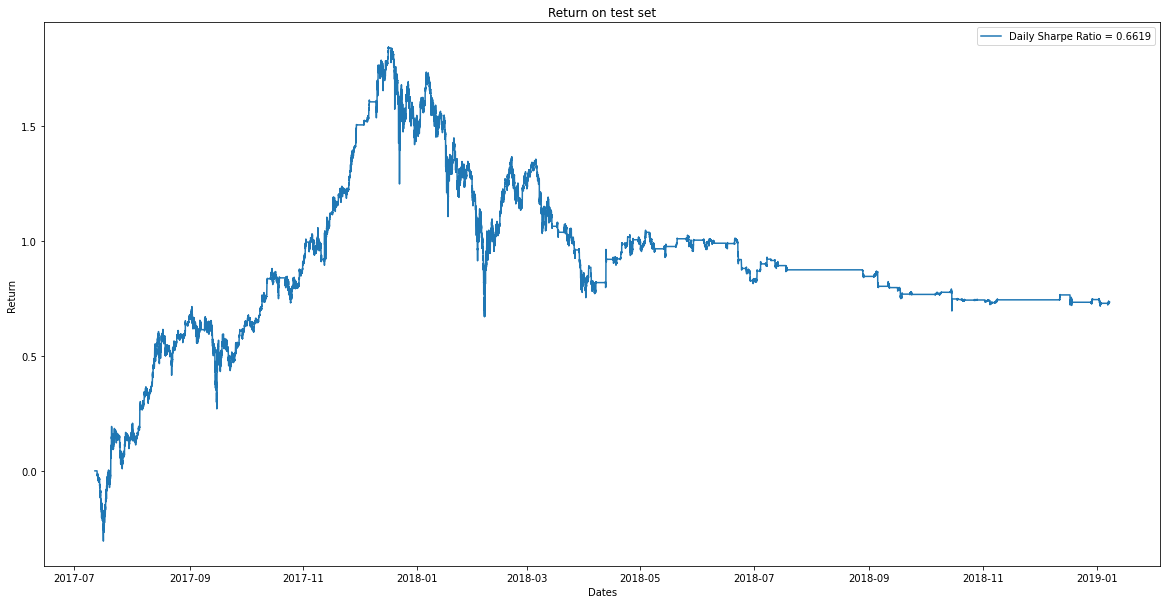

(0.7333871548363738, 0.6619252216600007)

In [ ]:
back_test(start_time=str(preds.index.min()), end_time=str(preds.index.max()), vol_threshold_span=144, ewm_span=100, open_constant=1, close_constant=0.1, mode='test', show=True, preds=preds)

* We can say ignoring costs and fractions, this strategy significantly beat the market.

* Is it possible to build this into a practically profitable strategy?